In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

#import conviction files
from conviction_helpers import *
from conviction_system_logic import *

This notebook uses the differential games framework developed by BlockScience. It is currently in private beta, and building towards a full open source release.

**Description:**

cadCAD is a Python library that assists in the processes of designing, testing and validating complex systems through simulation. At its core, cadCAD is a differential games engine that supports parameter sweeping and Monte Carlo analyses and can be easily integrated with other scientific computing Python modules and data science workflows.

To learn more about cadCAD, follow our [tutorial series](https://github.com/BlockScience/cadCAD-Tutorials/tree/master/01%20Tutorials)

**Installing cadCAD:**

cadCAD is in private beta. Tokens are issued to participants. Replace `<TOKEN>` in the installation URL below
```bash
pip3 install cadCAD --extra-index-url https://<TOKEN>@repo.fury.io/blockscience/
```

If you'd like to participate in the beta program, contact cadcad [at] block [dot] science.


In [2]:
#THIS policy is one of the main paramters of this system!

#maximum share of funds a proposal can take
default_beta = .2 #later we should set this to be param so we can sweep it
# tuning param for the trigger function
default_rho = default_beta**2

def trigger_threshold(requested, funds, supply, beta=default_beta , rho=default_rho):
    
    share = requested/funds
    if share < beta:
        return rho*supply/(beta-share)**2
    else: 
        return np.inf

In [3]:
dict1 = trigger_sweep('token_supply',trigger_threshold)

/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:96: RuntimeWarning: divide by zero encountered in log10
  demo_data_Z0[sof_ind,ts_ind] = np.log10(trigger)
/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:98: RuntimeWarning: invalid value encountered in double_scalars
  demo_data_Z2[sof_ind,ts_ind] = trigger/tc #share of maximum possible conviction
/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:99: RuntimeWarning: invalid value encountered in double_scalars
  demo_data_Z3[sof_ind,ts_ind] = np.log10(trigger/tc)


Text(0.15940000000000001, 1008990000.0, 'fixed alpha = 0.5')

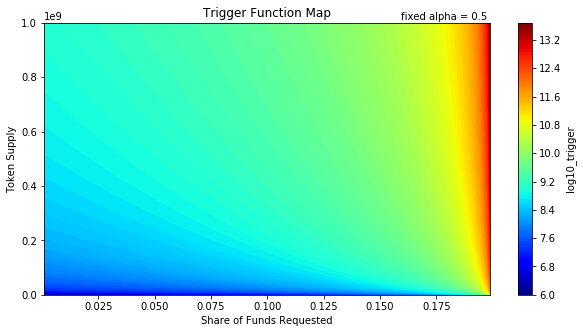

In [4]:
trigger_plotter(dict1['share_of_funds'],
                dict1['log10_trigger'], 
                'log10_trigger',
                dict1['total_supply'],
                'Token Supply')
axis = plt.axis()
plt.text(.2*axis[0]+.8*axis[1],axis[-1]*1.01, 'fixed alpha = 0.5')

In [5]:
dict2 = trigger_sweep('alpha',trigger_threshold)

In [6]:
dict2.keys()

dict_keys(['log10_trigger', 'trigger', 'share_of_max_conv', 'log10_share_of_max_conv', 'alpha', 'share_of_funds'])

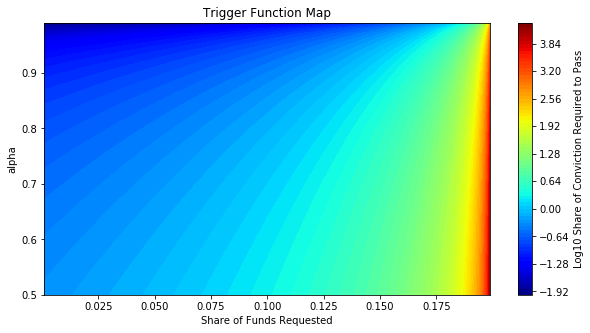

In [7]:
trigger_plotter(dict2['share_of_funds'],
                dict2['log10_share_of_max_conv'], 
                'Log10 Share of Conviction Required to Pass',
                dict2['alpha'],
                'alpha')


In [8]:
n= 25 #initial participants
m= 3 #initial proposals

initial_sentiment = .5

network, initial_funds, initial_supply, total_requested = initialize_network(n,m,total_funds_given_total_supply,trigger_threshold)

Note from Kris, consider: substitutibility of proposals st when a substitute passes, affinity for the others goes away; this will make the process more realistic because proposals will end up never passing.

implementation notes:
- create substitutability matrix (proposal x proposal)
- update accounting when thing pass: change affinities and should affect sentiments
- define a new 'type' of proposals for tracking 'dead' ones (no longer candidates = zero tokens in support)


In [9]:
proposals = get_nodes_by_type(network, 'proposal')
participants = get_nodes_by_type(network, 'participant')

In [10]:
#sample proposal
network.nodes[proposals[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'age': 0,
 'funds_requested': 44422.72592566299,
 'trigger': inf}

In [11]:
#sample participant
network.nodes[participants[0]]

{'type': 'participant',
 'holdings': 583.4204491141511,
 'sentiment': 0.13785461223155082}

In [12]:
#sample relationship participant to proposal
network.edges[(participants[0],proposals[0])]

{'affinity': 0.18493514019369206, 'tokens': 0, 'conviction': 0}

Explore the data created in initial conditions!

Text(0.5, 1.0, 'Histogram of Participants Token Holdings')

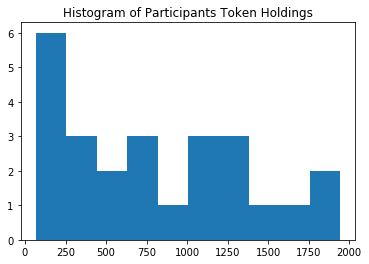

In [13]:
plt.hist([ network.nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')

Text(0.5, 1.0, 'Histogram of Proposals Funds Requested')

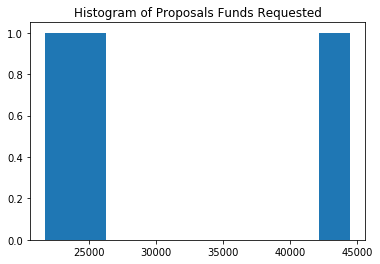

In [14]:
plt.hist([ network.nodes[i]['funds_requested'] for i in proposals])
plt.title('Histogram of Proposals Funds Requested')

Text(0.5, 1.0, 'Histogram of Affinities between Participants and Proposals')

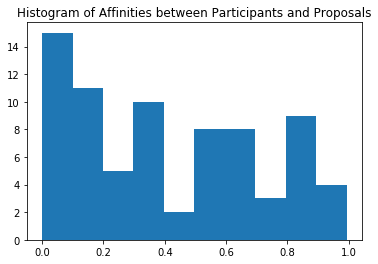

In [15]:
plt.hist([ network.edges[e]['affinity'] for e in network.edges])
plt.title('Histogram of Affinities between Participants and Proposals')

Text(0.5, 1.0, 'Histogram of Affinities between Participants and Proposals weighted by holdings')

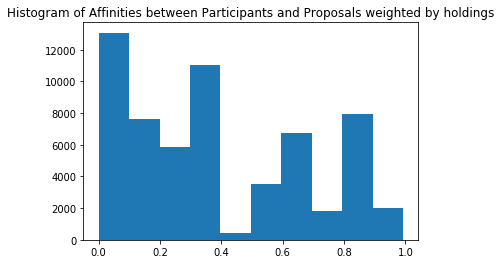

In [16]:
plt.hist([ network.edges[e]['affinity'] for e in network.edges], weights = [network.nodes[e[0]]['holdings']for e in network.edges],alpha = 1)
plt.title('Histogram of Affinities between Participants and Proposals weighted by holdings')

In [17]:
affinities = np.empty((n,m))
for i_ind in range(n):
    for j_ind in range(m):
        i = participants[i_ind]
        j = proposals[j_ind]
        affinities[i_ind][j_ind] = network.edges[(i,j)]['affinity']

Text(0.5, 106.33200000000001, 'participant_id')

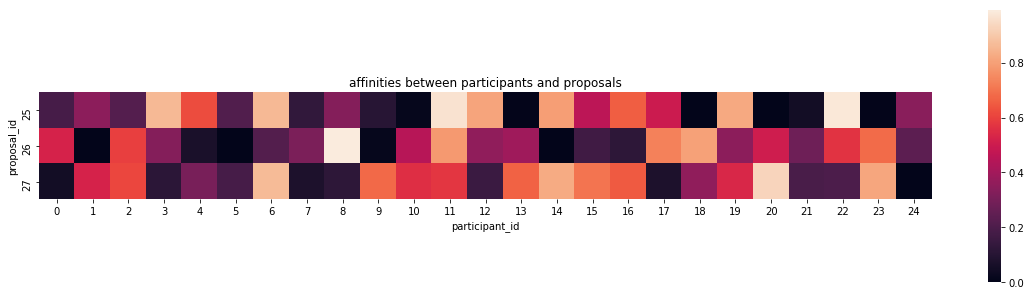

In [18]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=participants,
            yticklabels=proposals,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.ylabel('proposal_id')
plt.xlabel('participant_id')

In [19]:
#power of 1 token forever
conviction_capactity = [2,10]
alpha = [1-1/cc for cc in conviction_capactity]
print(alpha)

[0.5, 0.9]


In [20]:
params= {
    'sensitivity': [.75],
    'tmin': [7], #unit days; minimum periods passed before a proposal can pass
    'sentiment_decay': [.001], #termed mu in the state update function
    'alpha': alpha,
    'base_completion_rate': [10],
    'trigger_func': [trigger_threshold]
    }

In [21]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
time_periods_per_run = 250
monte_carlo_runs = 1

simulation_parameters = {
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
}

In [22]:
initial_conditions = {'network':network,
                      'supply': initial_supply,
                      'funds':initial_funds,
                      'sentiment': initial_sentiment}

In [23]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': driving_process
        },
        'variables': {
            'network': update_network,
            'funds':increment_funds,
            'supply':increment_supply
        }
    },
    {
      'policies': {
          'completion': check_progress #see if any of the funded proposals completes
        },
        'variables': { # The following state variables will be updated simultaneously
            'sentiment': update_sentiment_on_completion, #note completing decays sentiment, completing bumps it
            'network': complete_proposal #book-keeping
        }
    },
        {
      'policies': {
          'release': trigger_function #check each proposal to see if it passes
        },
        'variables': { # The following state variables will be updated simultaneously
            'funds': decrement_funds, #funds expended
            'sentiment': update_sentiment_on_release, #releasing funds can bump sentiment
            'network': update_proposals #reset convictions, and participants sentiments
                                        #update based on affinities
        }
    },
    { 
        'policies': { 
            'participants_act': participants_decisions, #high sentiment, high affinity =>buy
                                                        #low sentiment, low affinities => burn
                                                        #assign tokens to top affinities
        },
        'variables': {
            'supply': update_supply,
            'network': update_tokens #update everyones holdings 
                                    #and their conviction for each proposal
        }
    }
]

In [24]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [25]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import append_configs
from cadCAD import configs

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
config = append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=exec_context, configs=configs)
executor = Executor(exec_context, configs) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

multi_proc: [<cadCAD.configuration.Configuration object at 0x1a19f78a20>]


TypeError: 'NoneType' object is not iterable

In [ ]:
df = pd.DataFrame(raw_result)

In [ ]:
df.tail(5)

In [ ]:
df.supply.plot()

In [ ]:
df.sentiment.plot()

In [ ]:
df.plot(x='timestep', y='funds')

In [ ]:
def pad(vec, length,fill=True):
    
    if fill:
        padded = np.zeros(length,)
    else:
        padded = np.empty(length,)
        padded[:] = np.nan
        
    for i in range(len(vec)):
        padded[i]= vec[i]
        
    return padded

def make2D(key, data, fill=False):
    maxL = data[key].apply(len).max()
    newkey = 'padded_'+key
    data[newkey] = data[key].apply(lambda x: pad(x,maxL,fill))
    reshaped = np.array([a for a in data[newkey].values])
    
    return reshaped

In [ ]:
df['conviction'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['active_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['active_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['completed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))
df['completed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))

In [ ]:
df['funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal')]))
df['share_of_funds_requested'] = df.candidate_funds_requested/df.funds

df['share_of_funds_requested_all'] = df.funds_requested/df.funds

In [ ]:
df['triggers'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))
df['conviction_share_of_trigger'] = df.conviction/df.triggers
df['age'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))

In [ ]:
df['age_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') ]))
df['conviction_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') ]))
df['triggers_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal')  ]))

df['conviction_share_of_trigger_all'] = df.conviction_all/df.triggers_all

In [ ]:
rdf= df[df.substep==4].copy()

In [ ]:
last_net= df.network.values[-1]
last_props=get_nodes_by_type(last_net, 'proposal')
M = len(last_props)
last_parts=get_nodes_by_type(last_net, 'participant')
N = len(last_parts)

In [ ]:
affinities = np.empty((N,M))
for i_ind in range(N):
    for j_ind in range(M):
        i = last_parts[i_ind]
        j = last_props[j_ind]
        affinities[i_ind][j_ind] = last_net.edges[(i,j)]['affinity']

In [ ]:
dims = (100, 25)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            yticklabels=last_parts,
            xticklabels=last_props,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.xlabel('proposal_id')
plt.ylabel('participant_id')

In [ ]:
#working on deduplicating colors
#
#last_props=get_nodes_by_type(last_net, 'proposal')
#M = len(last_props)

#cm = plt.get_cmap('gist_rainbow')
#c= [cm(1.*j/M) for j in range(M)] 

In [ ]:
make2D('age_all', rdf)

In [ ]:
plt.plot(rdf.timestep,make2D('age_all', rdf))
plt.title('check age')

In [ ]:
rdf.plot(x='timestep',y=['candidate_count','active_count','completed_count'])

In [ ]:
rdf.plot(x='timestep',y=['candidate_funds','active_funds','completed_funds'])

In [ ]:
plt.semilogy(rdf.timestep,make2D('conviction_all', rdf))
plt.title('conviction by proposal')
plt.xlabel('time $t$')
plt.ylabel('conviction')

In [ ]:
plt.semilogy(make2D('age_all', rdf),make2D('conviction_all', rdf))
plt.title('conviction by proposal')
plt.xlabel('proposal age')
plt.ylabel('conviction')

In [ ]:
plt.plot(rdf.timestep,make2D('share_of_funds_requested_all', rdf))
plt.title('share_of_funds_requested by proposal')
plt.xlabel('time $t$')
plt.ylabel('share_of_funds_requested')

In [ ]:
plt.semilogy(make2D('age_all', rdf),make2D('share_of_funds_requested_all', rdf))
plt.title('share_of_funds_requested by proposal')
plt.xlabel('proposal age')
plt.ylabel('share_of_funds_requested')

In [ ]:
plt.loglog(make2D('share_of_funds_requested_all', rdf), make2D('conviction_all', rdf), '.')
plt.ylabel('conviction')
plt.xlabel('share_of_funds_requested')

In [ ]:
plt.semilogy(make2D('age_all', rdf), make2D('triggers_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')

In [ ]:
plt.loglog(make2D('conviction_all', rdf), make2D('triggers_all', rdf))
a = plt.axis()
plt.loglog(a[:2],a[2:], 'k',alpha=.5 )
plt.ylabel('triggers')
plt.xlabel('conviction')
plt.title('phase: Triggers & Conviction')

In [ ]:
plt.semilogy(rdf.timestep,make2D('conviction_share_of_trigger_all', rdf))
plt.title('conviction_share_of_trigger')
plt.xlabel('time $t$')
plt.ylabel('conviction_share_of_trigger')
plt.hlines(1,0,T, linestyle='--')

In [ ]:
plt.semilogy(make2D('age_all', rdf), make2D('conviction_share_of_trigger_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')
plt.hlines(1,0,T, linestyle='--')

In [ ]:
pos = {}
for ind in range(N):
    i = last_parts[ind] 
    pos[i] = np.array([0, 2*ind-N])

for ind in range(M):
    j = last_props[ind] 
    pos[j] = np.array([1, 2*N/M *ind-N])

#for i in last_parts:
#for j in last_props:
        

In [ ]:
edges = [e for e in last_net.edges]
max_tok = np.max([last_net.edges[e]['tokens'] for e in edges])

E = len(edges)

node_color = np.empty((M+N,4))
node_size = np.empty(M+N)

edge_color = np.empty((E,4))
cm = plt.get_cmap('Reds')

cNorm  = colors.Normalize(vmin=0, vmax=max_tok)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

In [ ]:
size_scale = 1/500
node_label = {}

for j in last_props:
    node_size[j] = last_net.nodes[j]['funds_requested']*size_scale
    if last_net.nodes[j]['status']=="candidate":
        node_color[j] = colors.to_rgba('blue')
        trigger = last_net.nodes[j]['trigger']
        #print(trigger)
        conviction = last_net.nodes[j]['conviction']
        #print(conviction)
        percent_of_trigger = str(int(100*conviction/trigger))+'%'
        #age = last_net.nodes[j]['age']
        node_label[j] = str(percent_of_trigger)
    elif last_net.nodes[j]['status']=="active":
        node_color[j] = colors.to_rgba('orange')
        node_label[j] = ''
    elif last_net.nodes[j]['status']=="completed":
        node_color[j] = colors.to_rgba('green')
        node_label[j] = ''

for i in last_parts:    
    node_size[i] = last_net.nodes[i]['holdings']*size_scale
    node_color[i] = colors.to_rgba('red')
    node_label[i] = ''

included_edges = []
for ind in range(E):
    e = edges[ind]
    tokens = last_net.edges[e]['tokens']
    if tokens >0:
        included_edges.append(e)
    #print(tokens)
    edge_color[ind] = scalarMap.to_rgba(tokens)

iE = len(included_edges)
included_edge_color = np.empty((iE,4))
for ind in range(iE):
    e = included_edges[ind]
    tokens = last_net.edges[e]['tokens']
    included_edge_color[ind] = scalarMap.to_rgba(tokens)

In [ ]:
nx.draw(last_net,
        pos=pos, 
        node_size = node_size, 
        node_color = node_color, 
        edge_color = included_edge_color, 
        edgelist=included_edges,
        labels = node_label)
plt.title('Tokens Staked by Partipants to Proposals')

In [ ]:
nets = rdf.network.values

In [ ]:
def snap_plot(nets, size_scale = 1/500, ani = False, dims = (20,20), savefigs=False ):
    
    last_net= df.network.values[-1]
    last_props=get_nodes_by_type(last_net, 'proposal')
    M = len(last_props)
    last_parts=get_nodes_by_type(last_net, 'participant')
    N = len(last_parts)
    pos = {}
    
    for ind in range(N):
        i = last_parts[ind] 
        pos[i] = np.array([0, 2*ind-N])

    for ind in range(M):
        j = last_props[ind] 
        pos[j] = np.array([1, 2*N/M *ind-N])
    
    if ani:
        figs = []
        fig, ax = plt.subplots(figsize=dims)
    
    if savefigs:
        counter = 0
        length = 10
        import string
        unique_id = ''.join([np.random.choice(list(string.ascii_letters + string.digits)) for _ in range(length)])
    for net in nets:
        edges = [e for e in net.edges]
        max_tok = np.max([net.edges[e]['tokens'] for e in edges])

        E = len(edges)
        
        net_props = get_nodes_by_type(net, 'proposal')
        net_parts = get_nodes_by_type(net, 'participant')
        net_node_label ={}
        
        num_nodes = len([node for node in net.nodes])
        
        node_color = np.empty((num_nodes,4))
        node_size = np.empty(num_nodes)

        edge_color = np.empty((E,4))
        cm = plt.get_cmap('Reds')

        cNorm  = colors.Normalize(vmin=0, vmax=max_tok)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    

        for j in net_props:
            node_size[j] = net.nodes[j]['funds_requested']*size_scale
            if net.nodes[j]['status']=="candidate":
                node_color[j] = colors.to_rgba('blue')
                trigger = net.nodes[j]['trigger']      
                conviction = net.nodes[j]['conviction']
                percent_of_trigger = "          "+str(int(100*conviction/trigger))+'%'
                net_node_label[j] = str(percent_of_trigger)
            elif net.nodes[j]['status']=="active":
                node_color[j] = colors.to_rgba('orange')
                net_node_label[j] = ''
            elif net.nodes[j]['status']=="completed":
                node_color[j] = colors.to_rgba('green')
                net_node_label[j] = ''

        for i in net_parts:    
            node_size[i] = net.nodes[i]['holdings']*size_scale
            node_color[i] = colors.to_rgba('red')
            net_node_label[i] = ''

        included_edges = []
        for ind in range(E):
            e = edges[ind]
            tokens = net.edges[e]['tokens']
            if tokens >0:
                included_edges.append(e)
            edge_color[ind] = scalarMap.to_rgba(tokens)

        iE = len(included_edges)
        included_edge_color = np.empty((iE,4))
        for ind in range(iE):
            e = included_edges[ind]
            tokens = net.edges[e]['tokens']
            included_edge_color[ind] = scalarMap.to_rgba(tokens)
        
        nx.draw(net,
                pos=pos, 
                node_size = node_size,
                node_color = node_color, 
                edge_color = included_edge_color, 
                edgelist=included_edges,
                labels = net_node_label)
        plt.title('Tokens Staked by Partipants to Proposals')
        if ani:
            nx.draw(net,
                    pos=pos, 
                    node_size = node_size,
                    node_color = node_color, 
                    edge_color = included_edge_color, 
                    edgelist=included_edges,
                    labels = net_node_label, ax=ax)
            figs.append(fig)
            
        else:
            nx.draw(net,
                pos=pos, 
                node_size = node_size,
                node_color = node_color, 
                edge_color = included_edge_color, 
                edgelist=included_edges,
                labels = net_node_label)
            plt.title('Tokens Staked by Partipants to Proposals')
            if savefigs:
                plt.savefig(unique_id+'_fig'+str(counter)+'.png')
                counter = counter+1
            plt.show()
        
    if ani:
        False
        #anim = animation.ArtistAnimation(fig, , interval=50, blit=True, repeat_delay=1000)
        #plt.show()
            

In [ ]:
snap_plot(nets, ani=False, savefigs=False)

In [ ]:
#totally failing at animating by trying to save a sequence of figures.
#snap_plot(nets, ani=True)

#saving the images to files works so there is almost the option to compile a video from the images